In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Fast food classification/

/gdrive/MyDrive/Fast food classification


In [4]:
ls

'burger king'/   mcdonalds/   starbucks/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Fast food classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 824 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['burger king', 'mcdonalds', 'starbucks']

In [10]:
len(dataset)

14

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[ 12.569031   13.9053955  16.905396 ]
  [147.54688   151.54688   154.54688  ]
  [149.53906   153.53906   156.53906  ]
  ...
  [167.        172.        165.       ]
  [167.        172.        165.       ]
  [167.        172.        165.       ]]

 [[ 12.782532   14.71875    17.71875  ]
  [150.16418   154.16418   157.16418  ]
  [152.3175    156.3175    159.3175   ]
  ...
  [167.        172.        165.       ]
  [167.        172.        165.       ]
  [167.        172.        165.       ]]

 [[ 12.829529   14.087341   17.087341 ]
  [151.3153    155.3153    158.3153   ]
  [154.57031   158.57031   161.57031  ]
  ...
  [167.        172.        165.       ]
  [167.        172.        165.       ]
  [167.        172.        165.       ]]

 ...

 [[  1.          1.          1.       ]
  [  1.2578125   1.2578125   1.2578125]
  [  2.          2.          2.       ]
  ...
  [141.61432   115.42969    89.85156  ]
  [138.35016   112.45453    91.140625 ]
  [135.2088    

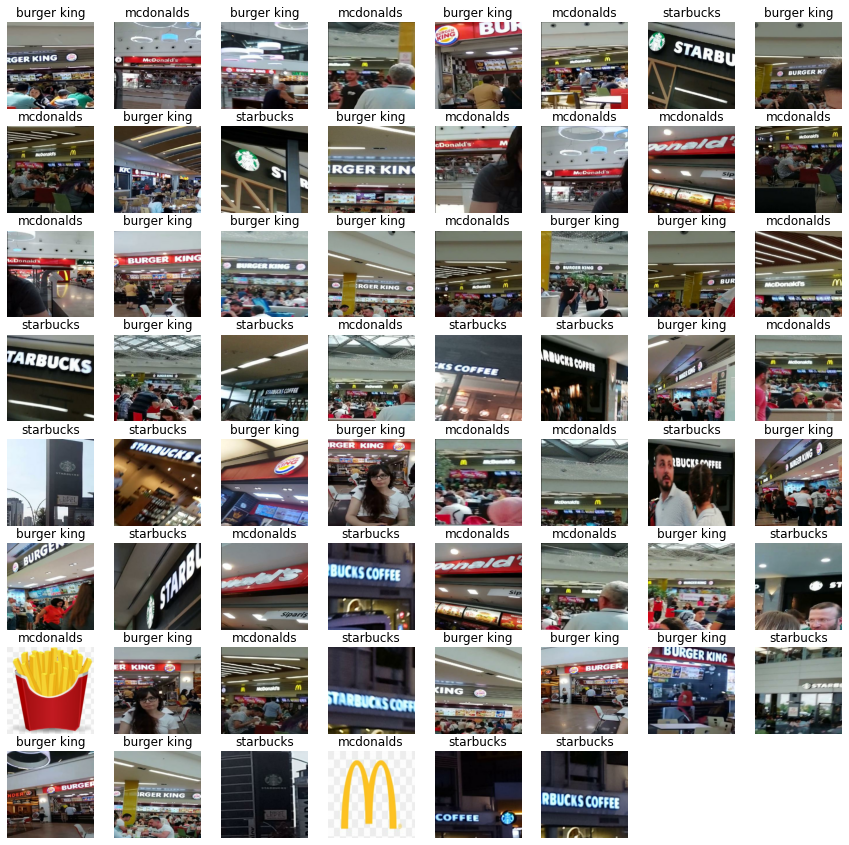

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='nadam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
11/11 [==============================] - 105s 7s/step - loss: 1.4356 - accuracy: 0.3824 - val_loss: 1.1385 - val_accuracy: 0.4677
Epoch 2/20
11/11 [==============================] - 70s 6s/step - loss: 1.1556 - accuracy: 0.4044 - val_loss: 1.0281 - val_accuracy: 0.5323
Epoch 3/20
11/11 [==============================] - 70s 6s/step - loss: 1.0925 - accuracy: 0.4075 - val_loss: 1.2891 - val_accuracy: 0.2742
Epoch 4/20
11/11 [==============================] - 72s 6s/step - loss: 1.1202 - accuracy: 0.4545 - val_loss: 1.2425 - val_accuracy: 0.2742
Epoch 5/20
11/11 [==============================] - 70s 6s/step - loss: 1.1026 - accuracy: 0.4451 - val_loss: 0.9380 - val_accuracy: 0.5484
Epoch 6/20
11/11 [==============================] - 69s 6s/step - loss: 1.0329 - accuracy: 0.4655 - val_loss: 0.9704 - val_accuracy: 0.5323
Epoch 7/20
11/11 [==============================] - 69s 6s/step - loss: 0.9460 - accuracy: 0.5705 - val_loss: 0.7441 - val_accuracy: 0.7581
Epoch 8/20
11/11 [=

In [21]:
model.evaluate(test_ds)

2/2 [==============================] - 6s 2s/step - loss: 0.2629 - accuracy: 0.9194


[0.2628704309463501, 0.9193548560142517]

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']

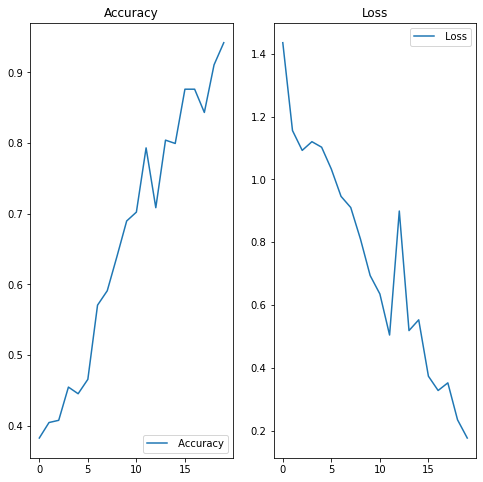

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

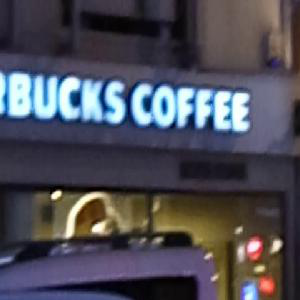

In [24]:
image_path = "/gdrive/My Drive/tunali_image_40.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [25]:
pred = model.predict(scaled_img)

In [26]:
output = class_names[np.argmax(pred)]

In [27]:
output

'starbucks'

In [28]:
model.save("Fast food classification.h5")